<a href="https://colab.research.google.com/github/sthepaut/SAFRAN_ENSAI_2025/blob/ENSAI_students/performancemodel_ENSAI/notebook/Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !git clone https://github.com/Anonymous-GT11/SAFRAN_ENSAI_2025
!git clone -b ENSAI_students https://github.com/Anonymous-GT11/SAFRAN_ENSAI_2025


fatal: destination path 'SAFRAN_ENSAI_2025' already exists and is not an empty directory.


In [3]:
# Verify that we have sucessfully clone the repo and go the place where the repo is stored
%cd /content/SAFRAN_ENSAI_2025
!ls

/content/SAFRAN_ENSAI_2025
Cie_0_Engine0.csv	performancemodel_ENSAI.zip
performancemodel_ENSAI	README.md


In [4]:
# install the package performance_model
%cd /content/SAFRAN_ENSAI_2025/performancemodel_ENSAI/
!pip install .

/content/SAFRAN_ENSAI_2025/performancemodel_ENSAI
Processing /content/SAFRAN_ENSAI_2025/performancemodel_ENSAI
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for performancemodel: filename=performancemodel-0.0.1-py3-none-any.whl size=30485 sha256=829c9e2ed6a3ad3a6a2ab7f4cb90754f404cc75d3e10b2a1857f616da1a4d2df
  Stored in directory: /tmp/pip-ephem-wheel-cache-ae_2pr6s/wheels/b4/6e/66/25433221b4a4d2ead6faf834b0fa81054260e4a8996e629ab9
Successfully built performancemodel


In [5]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm

from performancemodel.base_system import h_SCSF
from performancemodel.scenarios import simulate_degradation_trajectory, generate_multiple_trajectories
from performancemodel.plot import plot_trajectory


# Challenge SCSF

In this notebok we show how to create data for a challenge with the simulator SCSF implemented in this library and propose a solution to the challenge. This notebook will be divided into three parts :

1) Data Generation
2) Solver Construction
3) Tests and Results

## Data Generation

In this chapter we show how to construct degradation trajectories and how to get measurements from the simulator along the trajectories.

### Trajectory generation

The SCSF simulator has only two degrading modules, the compressor and the turbine. For each of this module, we have an health indicator that can vary between 1.95 and 1.02. We will now show how to construct degradation trajectories for each of this indicator.

In [6]:
traj = simulate_degradation_trajectory()
traj_waterwash =simulate_degradation_trajectory(waterwash="frequent")
traj_fast = simulate_degradation_trajectory(speed="fast")

In [7]:
plot_trajectory(traj)
plot_trajectory(traj_waterwash)
plot_trajectory(traj_fast)

In [8]:
S =  ['P3', 'P4', 'P5', 'T3', 'T4', 'T5', 'W2R', 'W5', 'W8R', 'Wf', 'F']
# Note that in this simulator there is no noise added, in the challenge noise should be added
test_measurements = h_SCSF(traj, S=S, as_dict=True)

In [9]:
data_measurements = pd.DataFrame(list(test_measurements))

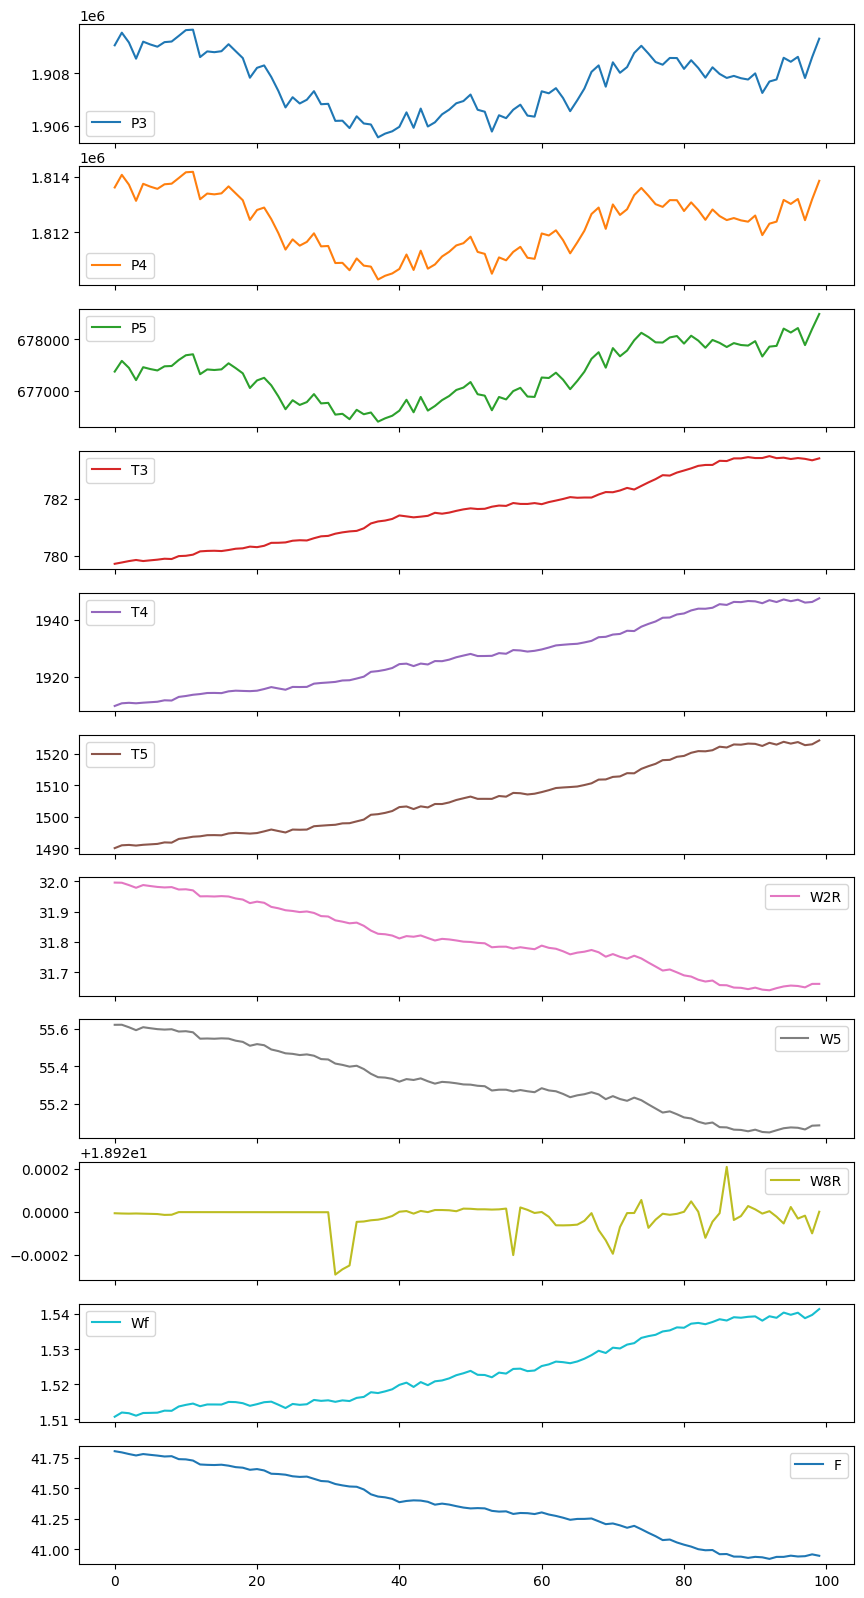

In [10]:
data_measurements.plot(subplots=True, figsize=(10, 20));

To create multiple trajetories in order to create a dataset for a challenge we implemented a simple version of a multiple trajectory generation function. This function can be found in src/scenarios.py and can be modified in order to create more adequate trajectories if needed.
By default it creates 100 trajectories.

In [11]:
multiple_traj = generate_multiple_trajectories(n_trajectories=100)

In [12]:
multiple_traj


[{'speed': 'fast',
  'waterwash': 'none',
  'size': 102,
  'trajectory': [[0.9955643434769251, 1.002855233510393],
   [np.float64(0.9949446456946633), np.float64(1.0024147968273005)],
   [np.float64(0.9940198726536968), np.float64(1.0019697531717193)],
   [np.float64(0.9933730179273437), np.float64(1.0014668426966846)],
   [np.float64(0.9925769206396168), np.float64(1.0008632829683894)],
   [np.float64(0.9921288645750853), np.float64(1.0001824843517033)],
   [np.float64(0.9915619837301679), np.float64(0.9997363362683657)],
   [np.float64(0.9911636309190457), np.float64(0.9990912097508263)],
   [np.float64(0.9908721721201753), np.float64(0.9987741783413284)],
   [np.float64(0.9909364121391582), np.float64(0.9982892206258959)],
   [np.float64(0.990168119058357), np.float64(0.9977146093341928)],
   [np.float64(0.9897722638487192), np.float64(0.9972163110027318)],
   [np.float64(0.989331669757703), np.float64(0.9968516486347307)],
   [np.float64(0.9889582460743225), np.float64(0.9964691518

In [13]:
# multiple_traj is a list of dictionary
print(multiple_traj[0].keys())

dict_keys(['speed', 'waterwash', 'size', 'trajectory'])


## Solver Construction

The challenge aims to estimate at each point of the trajectory the health indicators from the measurements. One can imagine many ways to do this task. We implement in this notebook a simple NLGPA (Non Linear Gas Path Analysis) with direct optimisation (least square) for demonstration purposes. The model that aims to estimate can be a trainable model or any other methods that comes to mind. If one want to use a trainable model, then a train set have to be generated in a previous step thanks to the simulator.

In [14]:

def inverse_nlgpa(y_measured, func_simu, x0=[1.0, 1.0], **kwargs):
    """
    y_measured: mesures (liste ou array)
    func_simu: simulateur f(x)
    x0: point initial pour l’optimisation
    kwargs: paramètres à passer à func_simu (ex: S=..., autre_param=...)
    """
    def loss_fn(x):
        y_pred = func_simu([x], S=S, **kwargs)
        return np.sum((np.array(y_pred) - np.array(y_measured))**2)

    result = minimize(loss_fn, x0, bounds=[(0.95, 1.02), (0.95, 1.02)], method="L-BFGS-B", options={"maxiter":100 , "disp": False})
    return result.x

def estimate_traj(measured_series, **kwargs):
    x0 = [1, 1]
    estimated_traj = []

    for i in range(len(measured_series)):
        estimated_traj_temp = inverse_nlgpa(measured_series[i], h_SCSF, x0=x0, **kwargs)
        x0 = estimated_traj_temp
        estimated_traj.append(estimated_traj_temp)

    return estimated_traj



## Tests and Results

In this chapter we test our method on a random trajectory computed thanks to the simulate_degradation_trajectory function. Since our method takes some time to compute estimation, we restrain ourself to a trajectory of size 10.

Then we compare our estimation with the true trajectory. We also compare observed measurements with the measurements we would obtain from the simulator with estimated performance indicators as inputs.

In [15]:
# Generate a test trajectory
traj_test = simulate_degradation_trajectory(speed='normal', waterwash='rare', size=10, seed=0)

# Simulated measurements
measured_series_test = list(h_SCSF(traj_test, S=S))



In [16]:
# This step might take some times because it is not optimized, so don't hesitate to change "max iter" option in inverse_nlgpa to run the code
# just to run it for debug
estimated_traj_test = estimate_traj(measured_series_test)


/tmp/ipython-input-1457987063.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.

/tmp/ipython-input-1457987063.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.

/tmp/ipython-input-1457987063.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.

/tmp/ipython-input-1457987063.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.

/tmp/ipython-input-1457987063.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.

/tmp/ipython-input-1457987063.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `

In [17]:
true_traj = np.array(traj_test)
est_traj = np.array(estimated_traj_test)

fig = go.Figure()

fig.add_trace(go.Scatter(y=true_traj[:, 0], mode="lines", line=dict(color="blue"), name="True trajectory compressor"))
fig.add_trace(go.Scatter(y=est_traj[:, 0], mode="lines", line=dict(color="blue", dash="dash"), name="Estimated trajectory compressor health"))

fig.add_trace(go.Scatter(y=true_traj[:, 1], mode="lines", line=dict(color="red"), name="True trajectory turbine"))
fig.add_trace(go.Scatter(y=est_traj[:, 1], mode="lines", line=dict(color="red", dash="dash"), name="Estimated trajectory turbine health"))

fig.show()




In [18]:
measured_series = pd.DataFrame(list(h_SCSF(traj_test, S=S, as_dict=True)))
measure_pred_series = pd.DataFrame(list(h_SCSF(estimated_traj_test, S=S, as_dict=True)))

palette = px.colors.qualitative.Prism
palette = palette + px.colors.qualitative.Prism

fig = make_subplots(rows=5, cols=3, subplot_titles=measured_series.columns)

i=0
j=0

show_legend=True
for col_ in measured_series.columns:

    fig.add_trace(go.Scatter(y=measured_series[col_], mode="lines", line=dict(color=palette[i]), name="True measurements", legendgroup="True measurements", showlegend=show_legend), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(y=measure_pred_series[col_], mode="lines", line=dict(color=palette[i], dash="dash"), name="Estimated measurements", legendgroup="Estimated measurements", showlegend=show_legend), row=i+1, col=j+1)

    j+=1
    if j > 2:
        j=0
        i+=1

    if show_legend:
        show_legend = False


fig.update_layout(height=200*5)
fig.show()



Next we also compute numerical score of our methodology. We use two different scoring :
1) RMSE error along the trajectory for each indicator
2) Slope error for each indicator

In [19]:
def trajectory_error(traj, est):

    traj = np.array(traj)
    est = np.array(est)
    out_0 = np.sqrt(np.sum((traj[:,0] - est[:,0])**2))
    out_1 = np.sqrt(np.sum((traj[:,1] - est[:,1])**2))

    out = [out_0, out_1]

    return out

def slope_error(traj, est): # We should certainly add a window size, because slope for 1 step time is not ok
    traj = np.array(traj)
    est = np.array(est)

    def total_slope(coord):
        return coord[-1] - coord[0]

    # Pente totale sur X
    slope_x_real = total_slope(traj[:, 0])
    slope_x_est = total_slope(est[:, 0])
    error_slope_x = slope_x_est - slope_x_real

    # Pente totale sur Y
    slope_y_real = total_slope(traj[:, 1])
    slope_y_est = total_slope(est[:, 1])
    error_slope_y = slope_y_est - slope_y_real

    return [error_slope_x, error_slope_y]


In [20]:
traj_error = trajectory_error(true_traj, est_traj)
slope_error = slope_error(true_traj, est_traj)
print(traj_error, slope_error)

[np.float64(0.0001440016433122032), np.float64(0.00013099920669135606)] [np.float64(-7.502007763893204e-07), np.float64(-6.648597750125163e-07)]


In [21]:
len(traj_error)

2

In [22]:
current_val1 = np.random.normal(1.0, 0.005)
current_val1

0.9988703017215429

In [23]:
np.random.normal(1.0, 0.005)

0.9917271461674388

# Try the simualation using only T5 and P3

In [ ]:
# create measurements
# traj_fast = simulate_degradation_trajectory(speed="fast") # Takes a lot of time
traj_fast = simulate_degradation_trajectory(speed='fast', waterwash='rare', size=10, seed=0)
# Selected sensors
S = ['P3', 'T5']
measured_series_fast = list(h_SCSF(traj_fast, S=S))
#
estimated_traj_test = estimate_traj(measured_series_fast)




/tmp/ipython-input-1457987063.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.



In [ ]:
# Visualising
true_traj = np.array(traj_fast)
est_traj = np.array(estimated_traj_test)

fig = go.Figure()

fig.add_trace(go.Scatter(y=true_traj[:, 0], mode="lines", line=dict(color="blue"), name="True trajectory compressor"))
fig.add_trace(go.Scatter(y=est_traj[:, 0], mode="lines", line=dict(color="blue", dash="dash"), name="Estimated trajectory compressor health"))

fig.add_trace(go.Scatter(y=true_traj[:, 1], mode="lines", line=dict(color="red"), name="True trajectory turbine"))
fig.add_trace(go.Scatter(y=est_traj[:, 1], mode="lines", line=dict(color="red", dash="dash"), name="Estimated trajectory turbine health"))

fig.show()

In [ ]:
# Plot measurement estimated vs true ones

measured_series = pd.DataFrame(list(h_SCSF(traj_test, S=S, as_dict=True)))
measure_pred_series = pd.DataFrame(list(h_SCSF(estimated_traj_test, S=S, as_dict=True)))

palette = px.colors.qualitative.Prism
palette = palette + px.colors.qualitative.Prism

fig = make_subplots(rows=1, cols=2, subplot_titles=measured_series.columns)

i=0
j=0

show_legend=True
for col_ in measured_series.columns:

    fig.add_trace(go.Scatter(y=measured_series[col_], mode="lines", line=dict(color=palette[i]), name="True measurements", legendgroup="True measurements", showlegend=show_legend), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(y=measure_pred_series[col_], mode="lines", line=dict(color=palette[i], dash="dash"), name="Estimated measurements", legendgroup="Estimated measurements", showlegend=show_legend), row=i+1, col=j+1)

    j+=1
    if j > 2:
        j=0
        i+=1

    if show_legend:
        show_legend = False


fig.update_layout(height=200*2)
fig.show()



## Updating the current simulator to facilitated reproduction

- This code was made to facilate the simulation on new sensors
- The final result is save in case someone want to re-use it without having to re-run the whole code

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.optimize import minimize
import time
import pickle

# ============================================================================
# CONFIGURATION SECTION - UPDATE THIS TO CHANGE SENSORS
# ============================================================================

# Select which sensors to use
SELECTED_SENSORS = ['P3', 'T5']  # Change this list to test different sensors

# Simulation parameters
SIMULATION_PARAMS = {
    'speed': 'fast',
    'waterwash': 'rare',
    'size': 2,
    'seed': 0
}

# Optimization parameters
OPTIMIZATION_PARAMS = {
    'x0': [1.0, 1.0],  # Initial guess
    'bounds': [(0.95, 1.02), (0.95, 1.02)],
    'method': "L-BFGS-B",
    'maxiter': 100
}

# Color scheme for plotting
COLOR_SCHEME = {
    'true_comp': 'blue',
    'est_comp': 'orange',  # Distinct from blue
    'true_turb': 'red',
    'est_turb': 'green'    # Distinct from red
}

# ============================================================================
# CORE FUNCTIONS
# ============================================================================

def inverse_nlgpa(y_measured, func_simu, S, x0=[1.0, 1.0], bounds=None, method="L-BFGS-B", maxiter=100):
    """
    Inverse problem solver using nonlinear optimization.

    Parameters:
    -----------
    y_measured : list or array
        Measured values
    func_simu : callable
        Simulator function f(x)
    S : list
        Sensor names to use
    x0 : list
        Initial point for optimization
    bounds : list of tuples
        Bounds for each parameter
    method : str
        Optimization method
    maxiter : int
        Maximum iterations

    Returns:
    --------
    array : Estimated parameters
    """
    def loss_fn(x):
        y_pred = func_simu([x], S=S)
        return np.sum((np.array(y_pred) - np.array(y_measured))**2)

    result = minimize(
        loss_fn,
        x0,
        bounds=bounds,
        method=method,
        options={"maxiter": maxiter, "disp": False}
    )
    return result.x


def estimate_traj(measured_series, func_simu, S, x0=[1, 1], **opt_params):
    """
    Estimate trajectory from measurement series.

    Parameters:
    -----------
    measured_series : list
        Series of measurements
    func_simu : callable
        Simulator function
    S : list
        Sensor names
    x0 : list
        Initial guess
    **opt_params : dict
        Additional optimization parameters

    Returns:
    --------
    list : Estimated trajectory
    float : Computation time in seconds
    """
    start_time = time.time()

    estimated_traj = []
    current_x0 = x0.copy()

    for i in range(len(measured_series)):
        estimated_point = inverse_nlgpa(
            measured_series[i],
            func_simu,
            S=S,
            x0=current_x0,
            **opt_params
        )
        current_x0 = estimated_point
        estimated_traj.append(estimated_point)

    computation_time = time.time() - start_time

    return estimated_traj, computation_time


# ============================================================================
# METRIC COMPUTATION FUNCTIONS
# ============================================================================

def trajectory_error(traj, est):
    """Calculate trajectory error (RMSE for each dimension)."""
    traj = np.array(traj)
    est = np.array(est)
    error_0 = np.sqrt(np.sum((traj[:, 0] - est[:, 0])**2))
    error_1 = np.sqrt(np.sum((traj[:, 1] - est[:, 1])**2))
    return [error_0, error_1]


def slope_error(traj, est):
    """Calculate slope error (difference in total degradation)."""
    traj = np.array(traj)
    est = np.array(est)

    # Total slope for compressor
    slope_comp_real = traj[-1, 0] - traj[0, 0]
    slope_comp_est = est[-1, 0] - est[0, 0]
    error_comp = slope_comp_est - slope_comp_real

    # Total slope for turbine
    slope_turb_real = traj[-1, 1] - traj[0, 1]
    slope_turb_est = est[-1, 1] - est[0, 1]
    error_turb = slope_turb_est - slope_turb_real

    return [error_comp, error_turb]


def compute_metrics(results):
    """
    Compute all metrics from results.

    Parameters:
    -----------
    results : dict
        Results dictionary from compute_estimation

    Returns:
    --------
    dict : Dictionary with all computed metrics
    """
    traj_err = trajectory_error(results['true_traj'], results['est_traj'])
    slope_err = slope_error(results['true_traj'], results['est_traj'])

    metrics = {
        'trajectory_error': {
            'compressor': traj_err[0],
            'turbine': traj_err[1]
        },
        'slope_error': {
            'compressor': slope_err[0],
            'turbine': slope_err[1]
        }
    }

    return metrics


def print_metrics(results, metrics):
    """Print formatted metrics."""
    print("\n" + "="*70)
    print(f"RESULTS FOR SENSORS: {results['sensors']}")
    print("="*70)
    print(f"\n⏱️  COMPUTATION TIME:")
    print(f"   - Trajectory generation:  {results['computation_time']['trajectory_gen']:.3f} seconds   - {results['computation_time']['trajectory_gen']/60:.3f} min")
    print(f"   - Measurement generation: {results['computation_time']['measurement_gen']:.3f} seconds  - {results['computation_time']['measurement_gen']/60:.3f} min ")
    print(f"   - Trajectory estimation:  {results['computation_time']['estimation']:.3f} seconds       - {results['computation_time']['estimation']/60:.3f} min")
    print(f"   - TOTAL TIME:             {results['computation_time']['total']:.3f} seconds            -  {results['computation_time']['total']/60:.3f} ")

    print(f"\n📊 ERROR METRICS:")
    print(f"   Trajectory Error (RMSE):")
    print(f"     - Compressor: {metrics['trajectory_error']['compressor']:.6f}")
    print(f"     - Turbine:    {metrics['trajectory_error']['turbine']:.6f}")
    print(f"   Slope Error:")
    print(f"     - Compressor: {metrics['slope_error']['compressor']:.6f}")
    print(f"     - Turbine:    {metrics['slope_error']['turbine']:.6f}")
    print("="*70 + "\n")


# ============================================================================
# PLOTTING FUNCTIONS
# ============================================================================

def plot_trajectories(results, colors=None):
    """
    Plot true vs estimated trajectories with distinct colors.

    Parameters:
    -----------
    results : dict
        Results dictionary from compute_estimation
    colors : dict, optional
        Custom color scheme
    """
    if colors is None:
        colors = COLOR_SCHEME

    true_traj = results['true_traj']
    est_traj = results['est_traj']

    fig = go.Figure()

    # True trajectories - solid lines
    fig.add_trace(go.Scatter(
        y=true_traj[:, 0],
        mode="lines",
        line=dict(color=colors['true_comp'], width=2),
        name="True - Compressor"
    ))
    fig.add_trace(go.Scatter(
        y=true_traj[:, 1],
        mode="lines",
        line=dict(color=colors['true_turb'], width=2),
        name="True - Turbine"
    ))

    # Estimated trajectories - dashed lines with different colors
    fig.add_trace(go.Scatter(
        y=est_traj[:, 0],
        mode="lines",
        line=dict(color=colors['est_comp'], width=2, dash="dash"),
        name="Estimated - Compressor"
    ))
    fig.add_trace(go.Scatter(
        y=est_traj[:, 1],
        mode="lines",
        line=dict(color=colors['est_turb'], width=2, dash="dash"),
        name="Estimated - Turbine"
    ))

    fig.update_layout(
        title=f"True vs Estimated Health Trajectories - Sensors: {results['sensors']}",
        xaxis_title="Time Step",
        yaxis_title="Health Index",
        height=500,
        hovermode='x unified'
    )
    fig.show()


def plot_measurements(results):
    """
    Plot true vs estimated measurements with distinct colors.

    Parameters:
    -----------
    results : dict
        Results dictionary from compute_estimation
    """
    measured_df = results['measured_series_df']
    measure_pred_df = results['measure_pred_series_df']

    n_sensors = len(measured_df.columns)

    # Use different color palettes for true vs estimated
    palette_true = px.colors.qualitative.Plotly
    palette_est = px.colors.qualitative.Set2

    fig = make_subplots(
        rows=1,
        cols=n_sensors,
        subplot_titles=[f"{col}" for col in measured_df.columns]
    )

    show_legend = True
    for i, col_ in enumerate(measured_df.columns):
        # True measurements - solid line
        fig.add_trace(
            go.Scatter(
                y=measured_df[col_],
                mode="lines",
                line=dict(color=palette_true[i % len(palette_true)], width=2),
                name="True measurements",
                legendgroup="True measurements",
                showlegend=show_legend
            ),
            row=1, col=i+1
        )
        # Estimated measurements - dashed line with different color
        fig.add_trace(
            go.Scatter(
                y=measure_pred_df[col_],
                mode="lines",
                line=dict(color=palette_est[i % len(palette_est)], width=2, dash="dash"),
                name="Estimated measurements",
                legendgroup="Estimated measurements",
                showlegend=show_legend
            ),
            row=1, col=i+1
        )
        show_legend = False

    fig.update_layout(
        title=f"True vs Estimated Measurements - Sensors: {results['sensors']}",
        height=400,
        hovermode='x unified'
    )
    fig.show()




def plot_all(results):
    """
    Generate all plots from results.

    Parameters:
    -----------
    results : dict
        Results dictionary from compute_estimation
    """
    print("📊 Generating plots...")
    plot_trajectories(results)
    plot_measurements(results)
    print("✓ Plots generated successfully!\n")


# ============================================================================
# COMPUTATION FUNCTIONS
# ============================================================================

def compute_estimation(sensors=None, sim_params=None, opt_params=None):
    """
    Run the trajectory estimation computation (time-consuming part).
    This function computes everything but doesn't plot.

    Parameters:
    -----------
    sensors : list, optional
        List of sensor names to use
    sim_params : dict, optional
        Simulation parameters
    opt_params : dict, optional
        Optimization parameters

    Returns:
    --------
    dict : Results dictionary containing all computed data
    """
    # Use defaults if not provided
    S = sensors if sensors is not None else SELECTED_SENSORS
    sim_p = sim_params if sim_params is not None else SIMULATION_PARAMS
    opt_p = opt_params if opt_params is not None else OPTIMIZATION_PARAMS

    print(f"\n{'='*70}")
    print(f" STARTING COMPUTATION")
    print(f"{'='*70}")
    print(f"Sensors: {S}")
    print(f"Simulation parameters: {sim_p}")
    print(f"{'='*70}\n")

    # Generate true trajectory
    print("⏳ Generating degradation trajectory...")
    traj_start = time.time()
    true_traj = simulate_degradation_trajectory(**sim_p)
    traj_time = time.time() - traj_start
    print(f"✓ Trajectory generated in {traj_time:.3f} seconds")

    # Generate measurements
    print("⏳ Generating measurements...")
    meas_start = time.time()

    measured_series = list(h_SCSF(true_traj, S=S))

    meas_time = time.time() - meas_start
    print(f"✓ Measurements generated in {meas_time:.3f} seconds")

    # Estimate trajectory
    print("⏳ Estimating trajectory (this may take a while)...")
    estimated_traj, estimation_time = estimate_traj(
        measured_series,
        h_SCSF,
        S=S,
        **opt_p
    )
    print(f"✓ Trajectory estimated in {estimation_time:.3f} seconds")

    # Convert to arrays
    true_traj_array = np.array(true_traj)
    est_traj_array = np.array(estimated_traj)

    # Generate measurement dataframes for plotting
    measured_df = pd.DataFrame(list(h_SCSF(true_traj, S=S, as_dict=True)))
    measure_pred_df = pd.DataFrame(list(h_SCSF(estimated_traj, S=S, as_dict=True)))

    print(f"\n✅ COMPUTATION COMPLETED!")
    print(f"Total computation time: {traj_time + meas_time + estimation_time:.3f} seconds\n")

    # Store all results
    results = {
        'true_traj': true_traj_array,
        'est_traj': est_traj_array,
        'sensors': S,
        'measured_series_df': measured_df,
        'measure_pred_series_df': measure_pred_df,
        'computation_time': {
            'trajectory_gen': traj_time,
            'measurement_gen': meas_time,
            'estimation': estimation_time,
            'total': traj_time + meas_time + estimation_time
        },
        'sim_params': sim_p,
        'opt_params': opt_p
    }

    return results


def save_results(results, filename='trajectory_results.pkl'):
    """
    Save results to a pickle file.

    Parameters:
    -----------
    results : dict
        Results dictionary
    filename : str
        Filename to save to
    """
    with open(filename, 'wb') as f:
        pickle.dump(results, f)
    print(f"💾 Results saved to {filename}")


def load_results(filename='trajectory_results.pkl'):
    """
    Load results from a pickle file.

    Parameters:
    -----------
    filename : str
        Filename to load from

    Returns:
    --------
    dict : Results dictionary
    """
    with open(filename, 'rb') as f:
        results = pickle.load(f)
    print(f"📂 Results loaded from {filename}")
    return results


# ============================================================================
# MAIN EXECUTION FUNCTIONS
# ============================================================================

def run_full_analysis(sensors=None, sim_params=None, opt_params=None, save_to_file=None):
    """
    Run complete analysis: computation + metrics + plots.

    Parameters:
    -----------
    sensors : list, optional
        List of sensor names to use
    sim_params : dict, optional
        Simulation parameters
    opt_params : dict, optional
        Optimization parameters
    save_to_file : str, optional
        If provided, save results to this file

    Returns:
    --------
    dict : Results dictionary
    dict : Metrics dictionary
    """
    # Compute estimation (time-consuming)
    results = compute_estimation(sensors, sim_params, opt_params)

    # Save if requested
    if save_to_file:
        save_results(results, save_to_file)

    # Compute metrics
    metrics = compute_metrics(results)

    # Print metrics
    print_metrics(results, metrics)

    # Generate plots
    plot_all(results)

    return results, metrics


def analyze_from_results(results):
    """
    Run analysis (metrics + plots) from pre-computed results.
    Use this to regenerate plots/metrics without recomputing.

    Parameters:
    -----------
    results : dict
        Pre-computed results dictionary

    Returns:
    --------
    dict : Metrics dictionary
    """
    # Compute metrics
    metrics = compute_metrics(results)

    # Print metrics
    print_metrics(results, metrics)

    # Generate plots
    plot_all(results)

    return metrics


# ============================================================================
# MAIN SCRIPT
# ============================================================================

if __name__ == "__main__":

    # ========================================================================
    # OPTION 1: Run full analysis (computation + metrics + plots)
    # ========================================================================
    results, metrics = run_full_analysis(save_to_file='my_results.pkl')


    # ========================================================================
    # OPTION 2: Only compute (no plots), then plot later
    # ========================================================================
    # # Step 1: Compute (time-consuming, do this once)
    # results = compute_estimation()
    # save_results(results, 'my_results.pkl')
    #
    # # Step 2: Later, just regenerate plots and metrics (fast)
    # results = load_results('my_results.pkl')
    # metrics = analyze_from_results(results)


    # ========================================================================
    # OPTION 3: Test multiple sensor combinations (compute once each)
    # ========================================================================
    # sensor_combinations = [
    #     ['P3', 'T5'],
    #     ['P1', 'T3'],
    #     ['P2', 'P3', 'T5']
    # ]
    #
    # all_results = {}
    # for i, sensors in enumerate(sensor_combinations):
    #     print(f"\n{'='*70}")
    #     print(f"TESTING SENSOR COMBINATION {i+1}/{len(sensor_combinations)}")
    #     print(f"{'='*70}")
    #
    #     # Compute and save
    #     results = compute_estimation(sensors=sensors)
    #     save_results(results, f'results_sensors_{i+1}.pkl')
    #     all_results[tuple(sensors)] = results
    #
    # # Later, reload and analyze all
    # for i, sensors in enumerate(sensor_combinations):
    #     results = load_results(f'results_sensors_{i+1}.pkl')
    #     metrics = analyze_from_results(results)


    # ========================================================================
    # OPTION 4: Just reload and replot existing results
    # ========================================================================
    # results = load_results('my_results.pkl')
    #
    # # Regenerate all plots and metrics
    # metrics = analyze_from_results(results)
    #
    # # Or just regenerate specific plots
    # plot_trajectories(results)
    # # plot_measurements(results)
    #
    # # Or just print metrics
    # metrics = compute_metrics(results)
    # print_metrics(results, metrics)

In [ ]:
#========================================================================
 #   OPTION 4: Just reload and replot existing results
#========================================================================
results = load_results('my_results.pkl')

# Regenerate all plots and metrics
# metrics = analyze_from_results(results)

# Or just regenerate specific plots
plot_trajectories(results)
plot_measurements(results)

# Or just print metrics
# metrics = compute_metrics(results)
# print_metrics(results, metrics)

#  Genetic Algorithm

This diagram was created using PlantText.
    https://www.planttext.com/

![Effect of Clamping](https://github.com/sthepaut/SAFRAN_ENSAI_2025/blob/ENSAI_students/performancemodel_ENSAI/notebook/diagram_GA2.png?raw=1)